In [1]:
import xarray as xr
import numpy as np
import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cf

2023-08-11 02:25:00.429366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
ERROR 1: PROJ: proj_create_from_database: Open of /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-wuuo72/share/proj failed


Load the model from keras file

In [2]:
model = load_model('ConvLSTM_model.keras')

2023-08-11 02:25:10.821850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 02:25:11.236506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78999 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0


Load the test dataset (should contain at least 6 days)

In [4]:
ds = xr.open_dataset('sst_test_2023.nc')

In [5]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['analysed_sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['analysed_sst'][time_index].values
    print(input_data_raw.shape)
    print(true_output_raw.shape)
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    print(prediction_postprocessed.shape)
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        input_data_raw = input_data_raw[..., np.newaxis]
        true_output_raw = true_output_raw[np.newaxis, ..., np.newaxis]
        prediction_postprocessed = prediction_postprocessed[np.newaxis, ...]
        
        all_data = np.concatenate([input_data_raw, prediction_postprocessed, true_output_raw])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title='',reverse = False):
            sample_2d = np.squeeze(sample)
            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Mercator()})

            p = ax.pcolormesh(dataset.lon,dataset.lat,sample_2d, cmap =cm.Spectral_r, vmin=vmin, vmax=vmax,transform=ccrs.PlateCarree())
            # if reverse == True:
            #     plt.gca().invert_yaxis()
            ax.coastlines()
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0)
            gl.top_labels = False
            gl.right_labels = False
            plt.title(title)
            # Add a colorbar
            cbar = plt.colorbar(p, ax=ax, orientation='vertical')
            cbar.set_label('Temperature, K')
            
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            name_in = str(dataset["time"].values[time_index-window_size+i]).split('T')[0]
            plot_sample(frame, title=f'Input Frame {i+1} ({name_in})')
        
        # show predicted output
        name_pr = date_to_predict.split('T')[0]
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({name_pr})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({name_pr})')
        
      

    return input_data_raw, prediction_postprocessed, true_output_raw

In [6]:
def compute_mse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    squared_diff = (y_true[mask] - y_pred[mask]) ** 2
    return np.mean(squared_diff)

In [10]:
def create_land_mask(data): 
    data[data==0] = np.nan
    land_mask = np.isnan(data)
    return (land_mask)

land_mask_resized = create_land_mask(ds.analysed_sst.values[0,:,:])

np.save('land_mask.npy', land_mask_resized)

(5, 401, 451)
(401, 451)
1/1 [==============================] - 0s 20ms/step
(401, 451, 1)


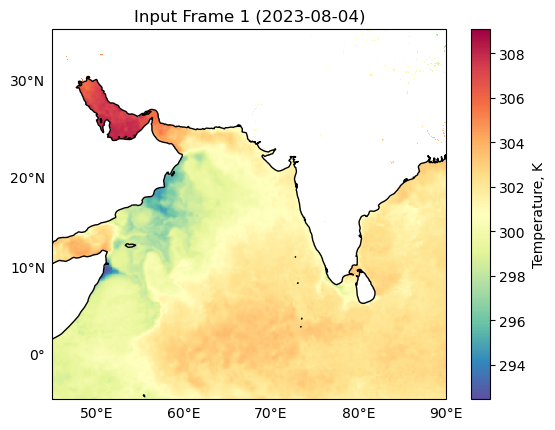

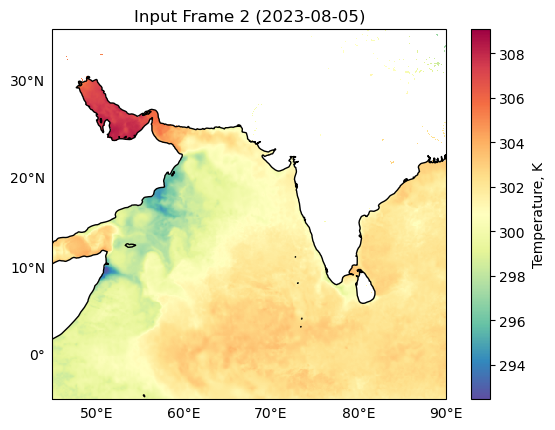

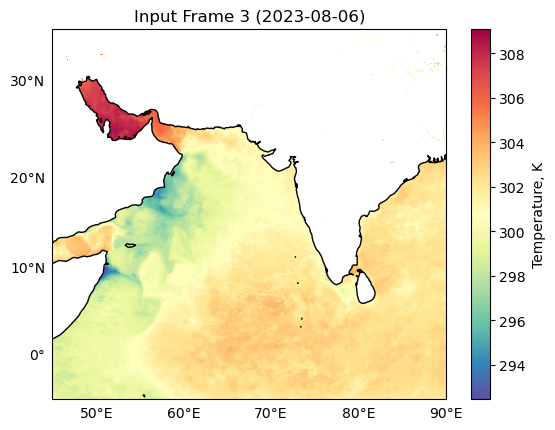

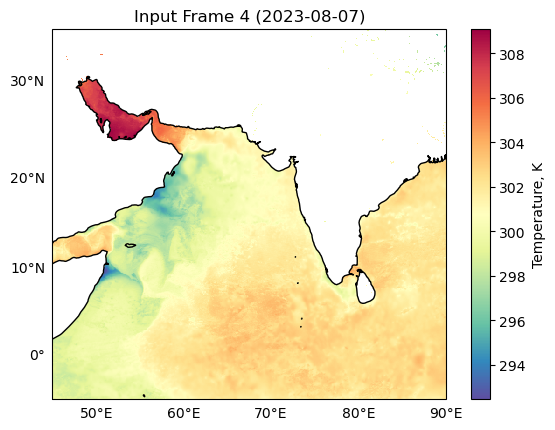

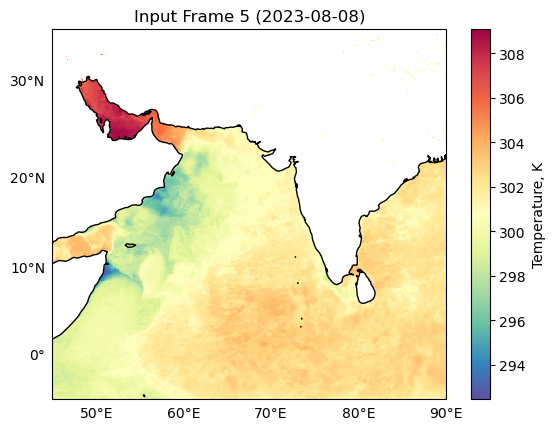

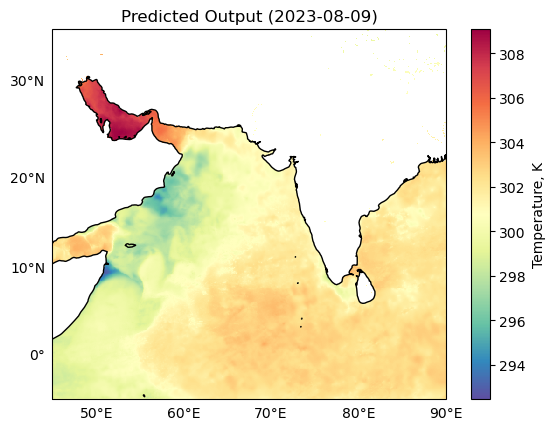

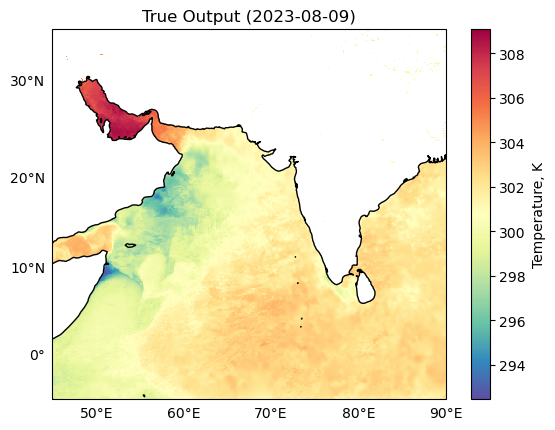

MSE between Predicted Output and True Output: 0.04806656017899513
MSE between Last Input Frame and True Output: 0.053321436047554016


In [11]:
date_to_predict = '2023-08-09T09:00:00.000000000'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, ds)

predicted_mse = compute_mse(true_output, predicted_output)
print(f"MSE between Predicted Output and True Output: {predicted_mse}")

last_input_frame = input_data[-1]
last_input_frame_2d = np.squeeze(last_input_frame)
true_output_2d = np.squeeze(true_output)
last_frame_mse = compute_mse(true_output_2d, last_input_frame_2d)
print(f"MSE between Last Input Frame and True Output: {last_frame_mse}")